<a href="https://colab.research.google.com/github/Mushfique12/IGTE/blob/main/pinns_magnetostatic_poisson_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
from typing import Callable

import matplotlib.pyplot as plt
import torch
from scipy.integrate import solve_ivp
from torch import nn
import numpy as np
import scipy.io
import time

In [100]:
R = 1.0
F0 = 1.0

class NNApproximator(nn.Module):
    def __init__(self, num_hidden: int, dim_hidden: int, act=nn.ReLU()):

        super().__init__()

        self.layer_in = nn.Linear(2, dim_hidden)
        self.layer_out = nn.Linear(dim_hidden, 1)

        num_middle = num_hidden - 1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
        )
        self.act = act

    def forward(self, x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        return self.layer_out(out)


def f(nn: NNApproximator, x: torch.Tensor) -> torch.Tensor:
    """Compute the value of the approximate solution from the NN model"""
    return nn(x)


def df(nn: NNApproximator, x: torch.Tensor = None, order: int = 2) -> torch.Tensor:
    """Compute neural network derivative with respect to input features using PyTorch autograd engine"""
    df_value = f(nn, x)
    # print('x.shape', x.shape)
    # output_dim = [int(x.shape[0]), 1]
    # print('output_dim', output_dim)
    # output_ = torch.ones(output_dim)
    # print('output_shape', output_.shape)

    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            x,
            # grad_outputs=torch.ones(output_dim),
            torch.ones_like(df_value),
            # grad_outputs=torch.ones_like(x),
            create_graph=True,
            retain_graph=True,
        )[0]

    return df_value


def compute_loss(
    nn1: NNApproximator, 
    nn2: NNApproximator, 
    x1: torch.Tensor = None, 
    x2: torch.Tensor = None, 
    xi: torch.Tensor = None, 
    xb: torch.Tensor = None, 
    ub: torch.Tensor = None,
    ufi: torch.Tensor = None,
    verbose: bool = False
) -> torch.float:

    """Compute the full loss function as interior loss + boundary loss
    This custom loss function is fully defined with differentiable tensors therefore
    the .backward() method can be applied to it
    """
    multiplier = 60
    interior_loss_1 = df(nn1, x1, order=2) - torch.exp(x1)
    interior_loss_2 = df(nn2, x2, order=2) - (-50)

    u1_i = f(nn1, xi)
    u2_i = f(nn2, xi)
    uAvg_i = (u1_i + u2_i)/2

    interface_loss_1 = uAvg_i - u1_i
    interface_loss_2 = uAvg_i - u2_i

    actual_interface_loss_1 = torch.sub(ufi, u1_i)
    actual_interface_loss_2 = torch.sub(ufi, u2_i)

    # Interface 1
    interface_1 = df(nn1, xi, order=2)
    interface_2 = df(nn2, xi, order=2)

    # Residual Continuity conditions on the interfaces
    res_loss = (interface_1 - torch.exp(xi)) - (interface_2 - (-50))
    
    # boundary = xb
    # boundary.requires_grad = True
    ub_pred = f(nn1, xb)
    boundary_loss = torch.sub(ub, ub_pred)

    loss_1 = \
        interior_loss_1.pow(2).mean() + \
        multiplier * interface_loss_1.pow(2).mean() + \
        multiplier * boundary_loss.pow(2).mean() + \
        multiplier * actual_interface_loss_1.pow(2).mean() + \
        res_loss.pow(2).mean()

    loss_2 = \
        interior_loss_2.pow(2).mean() + \
        multiplier * interface_loss_2.pow(2).mean() + \
        multiplier * actual_interface_loss_2.pow(2).mean() + \
        res_loss.pow(2).mean()

    final_loss = loss_1 + loss_2

    return final_loss


def train_model(
    nn1: NNApproximator, 
    nn2: NNApproximator, 
    loss_fn: Callable,
    learning_rate: int = 0.01,
    max_epochs: int = 1_000,
):

    loss_evolution_1, loss_evolution_2 = [], []

    optimizer = torch.optim.NAdam([
                {'params': nn1.parameters(), 'lr': learning_rate},
                {'params': nn2.parameters(), 'lr': learning_rate}
            ])

    for epoch in range(max_epochs):

        try:
            loss = loss_fn(nn1, nn2)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 1000 == 0:
                print(f"Epoch: {epoch} - Loss # 1: {float(loss):>7f}")

            loss_evolution_1.append(loss.detach().numpy())

        except KeyboardInterrupt:
            break

    return [nn1, nn2], np.array(loss_evolution_1)


def check_gradient(nn: NNApproximator, x: torch.Tensor = None) -> bool:

    eps = 1e-4
    dfdx_fd = (f(nn, x + eps) - f(nn, x - eps)) / (2 * eps)
    dfdx_sample = df(nn, x, order=1)

    return torch.allclose(dfdx_fd.T, dfdx_sample.T, atol=1e-2, rtol=1e-2)




## Load data

In [101]:
# Boundary points from subdomian 1
N_ub   = 250

# Residual points in three subdomains
N_f1   = 500
N_f2   = 200

# Interface points along the two interfaces
N_I1   = 150

# NN architecture in each subdomain
layers1 = [2, 400, 400, 100, 1]
# layers2 = [2, 400, 200, 100, 100, 1]
layers2 = [2, 100, 100, 40, 1]

mu1 = 1
mu2 = 1

Max_iter = 5000

# Load training data (boundary points), residual and interface points from .mat file
# All points are generated in Matlab
data = scipy.io.loadmat('/content/PINN_Lin_mat.mat')



In [102]:
x_f1 = data['x_domain'].flatten()[:,None]
y_f1 = data['y_domain'].flatten()[:,None]
x_f2 = data['x_coil'].flatten()[:,None]
y_f2 = data['y_coil'].flatten()[:,None]

x_i  = data['x_i'].flatten()[:,None]
y_i  = data['y_i'].flatten()[:,None]

x_boundary   = data['x_boundary'].flatten()[:,None]
y_boundary   = data['y_boundary'].flatten()[:,None]

u_boundary  = data['u_boundary'].flatten()[:,None]

u_exact1 = data['u_domain'].flatten()[:,None]
u_exact2 = data['u_coil'].flatten()[:,None]

u_exacti = data['u_i'].flatten()[:,None]

X_f1 = np.hstack((x_f1.flatten()[:,None], y_f1.flatten()[:,None]))
X_f2 = np.hstack((x_f2.flatten()[:,None], y_f2.flatten()[:,None]))

X_fi = np.hstack((x_i.flatten()[:,None], y_i.flatten()[:,None]))

X_ub = np.hstack((x_boundary.flatten()[:,None], y_boundary.flatten()[:,None]))

# Points in the whole  domain
# x_total =  data['x_total'].flatten()[:,None] 
# y_total =  data['y_total'].flatten()[:,None]

# X_star1 = np.hstack((x_f1.flatten()[:,None], y_f1.flatten()[:,None]))
# X_star2 = np.hstack((x_f2.flatten()[:,None], y_f2.flatten()[:,None]))

# Randomly select the residual points from sub-domains
idx1 = np.random.choice(X_f1.shape[0], N_f1, replace=False)    
X_f1_train = np.float32(X_f1[idx1,:])

idx2 = np.random.choice(X_f2.shape[0], N_f2, replace=False)    
X_f2_train = np.float32(X_f2[idx2,:])

# Randomly select boundary points
idx4 = np.random.choice(X_ub.shape[0], N_ub, replace=False)
X_ub_train = np.float32(X_ub[idx4,:])
ub_train   = np.float32(u_boundary[idx4,:])

# Randomly select the interface points along two interfaces
idxi1 = np.random.choice(X_fi.shape[0], N_I1, replace=False)    
X_fi_train = np.float32(X_fi[idxi1,:])
ub_fi1_train = np.float32(u_exacti[idxi1,:])

In [103]:
type(X_f1_train[1, 0])

numpy.float32

## Train Pinns

In [104]:
from functools import partial

# domain = [0.0, 1.0]
# x = torch.linspace(domain[0], domain[1], steps=10, requires_grad=True)
# x = x.reshape(x.shape[0], 1)

x1 = torch.tensor(X_f1_train, requires_grad=True) 
x2 = torch.tensor(X_f2_train, requires_grad=True) 
xi = torch.tensor(X_fi_train, requires_grad=True) 
xb = torch.tensor(X_ub_train, requires_grad=True)
ub = torch.tensor(ub_train)
ub = torch.zeros_like(ub)
ufi = torch.tensor(ub_fi1_train)

nn_approximator_1 = NNApproximator(4, 10)
nn_approximator_2 = NNApproximator(2, 10)
# assert check_gradient(nn_approximator, x)

# f_initial = f(nn_approximator, x)
# ax.plot(x.detach().numpy(), f_initial.detach().numpy(), label="Initial NN solution")

# train the PINN
loss_fn = partial(compute_loss,     
                  x1 = x1, 
                  x2 = x2, 
                  xi = xi, 
                  xb = xb, 
                  ub = ub,
                  ufi = ufi,
                  verbose=True)

nn_approximator_trained, loss_evolutions = train_model(
                                                      nn_approximator_1,
                                                      nn_approximator_2,
                                                      loss_fn=loss_fn, 
                                                      learning_rate=0.0008, 
                                                      max_epochs=20000
                                                    )

# x_eval = torch.linspace(domain[0], domain[1], steps=100).reshape(-1, 1)


Epoch: 0 - Loss # 1: 8042.916016
Epoch: 1000 - Loss # 1: 7703.703125
Epoch: 2000 - Loss # 1: 7703.661133
Epoch: 3000 - Loss # 1: 7703.651367
Epoch: 4000 - Loss # 1: 7703.645020
Epoch: 5000 - Loss # 1: 7703.641602
Epoch: 6000 - Loss # 1: 7703.638672
Epoch: 7000 - Loss # 1: 7703.636719
Epoch: 8000 - Loss # 1: 7703.634766
Epoch: 9000 - Loss # 1: 7703.633301
Epoch: 10000 - Loss # 1: 7703.630859
Epoch: 11000 - Loss # 1: 7703.628906
Epoch: 12000 - Loss # 1: 7703.628418
Epoch: 13000 - Loss # 1: 7703.627441
Epoch: 14000 - Loss # 1: 7703.626465
Epoch: 15000 - Loss # 1: 7703.625977
Epoch: 16000 - Loss # 1: 7703.625000
Epoch: 17000 - Loss # 1: 7703.625000
Epoch: 18000 - Loss # 1: 7703.624512
Epoch: 19000 - Loss # 1: 7703.624023


In [105]:
nn_approximator_1 = NNApproximator(4, 10)
nn_approximator_2 = NNApproximator(2, 10)

In [106]:
from torchsummary import summary
print(nn_approximator_1)

NNApproximator(
  (layer_in): Linear(in_features=2, out_features=10, bias=True)
  (layer_out): Linear(in_features=10, out_features=1, bias=True)
  (middle_layers): ModuleList(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
  (act): ReLU()
)


In [107]:
print(nn_approximator_2)

NNApproximator(
  (layer_in): Linear(in_features=2, out_features=10, bias=True)
  (layer_out): Linear(in_features=10, out_features=1, bias=True)
  (middle_layers): ModuleList(
    (0): Linear(in_features=10, out_features=10, bias=True)
  )
  (act): ReLU()
)


## predict

In [108]:
# Solution prediction

nn1_trained = nn_approximator_trained[0]
nn2_trained = nn_approximator_trained[1]

u_pred1 = nn1_trained(torch.tensor(np.float32(X_f1))).detach().numpy()
u_pred2 = nn2_trained(torch.tensor(np.float32(X_f2))).detach().numpy()

u_pred_i1 = nn1_trained(torch.tensor(np.float32(X_fi))).detach().numpy()
u_pred_i2 = nn2_trained(torch.tensor(np.float32(X_fi))).detach().numpy()

u_pred_b = nn2_trained(torch.tensor(np.float32(X_ub))).detach().numpy()

u_pred = np.concatenate([u_pred1, u_pred2, (u_pred_i1 + u_pred_i2)/2, u_pred_b])

In [109]:
u_exact1 = data['u_domain'].flatten()[:,None]
u_exact2 = data['u_coil'].flatten()[:,None]

u_exacti = data['u_i'].flatten()[:,None]

u_exact = np.concatenate([u_exact1, u_exact2, u_exacti, u_boundary])


In [110]:
x_tot = np.concatenate([x_f1, x_f2, x_i, x_boundary])
y_tot = np.concatenate([y_f1, y_f2, y_i, y_boundary])
print(x_tot.shape, y_tot.shape, u_pred.shape, u_exact.shape)

(2693, 1) (2693, 1) (2693, 1) (2693, 1)


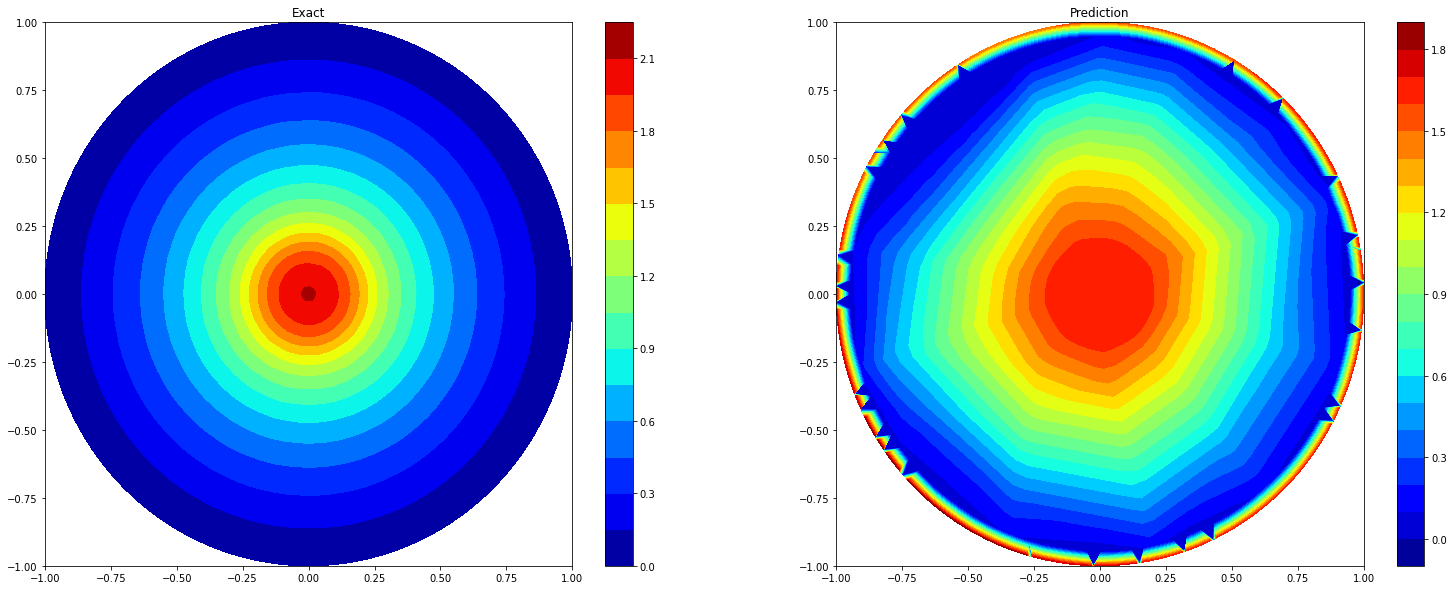

In [111]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np

np.random.seed(19680801)
npts = 200
ngridx = 100
ngridy = 200
x = x_tot.squeeze()
y = y_tot.squeeze()
up = u_pred.squeeze()
uex = u_exact.squeeze()

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(26,10))

## True Exact
# ax2.tricontour(x, y, z, levels=20, linewidths=0.5, colors='k')
cntr1 = ax1.tricontourf(x, y, uex, levels=20, cmap="jet")

fig.colorbar(cntr1, ax=ax1)
# ax2.plot(x, y, 'ko', ms=3)
ax1.set(xlim=(-1, 1), ylim=(-1, 1))
ax1.set_title('Exact')


## Predictions
# ax2.tricontour(x, y, z, levels=20, linewidths=0.5, colors='k')
cntr2 = ax2.tricontourf(x, y, up, levels=20, cmap="jet")

fig.colorbar(cntr2, ax=ax2)
# ax2.plot(x, y, 'ko', ms=3)
ax2.set(xlim=(-1, 1), ylim=(-1, 1))
ax2.set_title('Prediction')

plt.subplots_adjust(hspace=0.5)
# plt.savefig('exact_pred_TL_20points.png', dpi=400)
plt.show()

## Rough

In [112]:
# numeric solution
def logistic_eq_fn(x, y):
    return R * x * (1 - x)

numeric_solution = solve_ivp(
    logistic_eq_fn, domain, [F0], t_eval=x_eval.squeeze().detach().numpy()
)

# plotting
fig, ax = plt.subplots()

f_final_training = f(nn_approximator_trained, x)
f_final = f(nn_approximator_trained, x_eval)

ax.scatter(x.detach().numpy(), f_final_training.detach().numpy(), label="Training points", color="red")
ax.plot(x_eval.detach().numpy(), f_final.detach().numpy(), label="NN final solution")
ax.plot(
    x_eval.detach().numpy(),
    numeric_solution.y.T,
    label=f"Analytic solution",
    color="green",
    alpha=0.75,
)
ax.set(title="Logistic equation solved with NNs", xlabel="t", ylabel="f(t)")
ax.legend()

fig, ax = plt.subplots()
ax.semilogy(loss_evolution)
ax.set(title="Loss evolution", xlabel="# epochs", ylabel="Loss")
ax.legend()

plt.show()

NameError: ignored